# Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

from khan_helpers import Experiment
from khan_helpers.constants import (
    BOS_LECTURE_COLOR,
    BOS_QUESTION_COLOR,
    FIG_DIR,
    FORCES_LECTURE_COLOR,
    FORCES_QUESTION_COLOR,
    GENERAL_QUESTION_COLOR
)
from khan_helpers.functions import (
    disable_logging, 
    format_stats,
    pearsonr_ci,
    set_figure_style, 
    show_source
)

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Show some functions from `khan_helpers`

In [2]:
show_source(pearsonr_ci)

In [3]:
show_source(format_stats)

In [4]:
show_source(set_figure_style)

In [5]:
show_source(disable_logging)

# Format data

In [6]:
exp = Experiment()

forces_traj = exp.forces_traj
bos_traj = exp.bos_traj

all_questions = exp.question_vectors
forces_questions = all_questions[np.flatnonzero(exp.questions['lecture'] == 1)]
bos_questions = all_questions[np.flatnonzero(exp.questions['lecture'] == 2)]
general_questions = all_questions[np.flatnonzero(exp.questions['lecture'] == 0)]

In [7]:
forces_lec_vars = forces_traj.var(axis=0)
bos_lec_vars = bos_traj.var(axis=0)
forces_qs_vars = forces_questions.var(axis=0)
bos_qs_vars = bos_questions.var(axis=0)
gen_qs_vars = general_questions.var(axis=0)

# Topic variability figure

## Panel A

In [8]:
N_TOPICS = forces_traj.shape[1]

# topic with highest variance across lecture timepoints
forces_max_var_topic = forces_lec_vars.argmax() + 1
bos_max_var_topic = bos_lec_vars.argmax() + 1

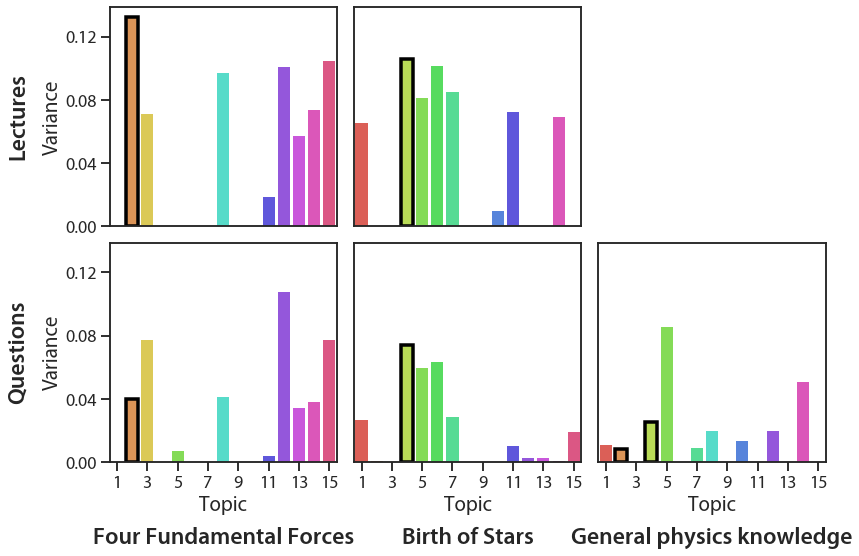

In [9]:
with sns.plotting_context('talk', font_scale=1.1), sns.axes_style('ticks'):
    set_figure_style()
    palette = sns.color_palette('hls', N_TOPICS)

    fig, axarr = plt.subplots(2, 3, sharex=True, sharey='all')
    fig.set_size_inches(12, 8)
    axarr = axarr.flatten()

    for i, topic_vars in enumerate([forces_lec_vars, 
                                    bos_lec_vars, 
                                    None,
                                    forces_qs_vars,
                                    bos_qs_vars,
                                    gen_qs_vars]):
        ax = axarr[i]
        if topic_vars is None:
            ax.axis('off')
            continue

        ax.bar(x=range(1, N_TOPICS + 1), 
               height=topic_vars, 
               color=palette, 
               edgecolor='none')
        ax.set_xlim(.5, N_TOPICS + 0.5)
        ax.set_xticks(range(1, N_TOPICS + 1, 2))
        
        if i == 0:
            ax.set_ylabel('Variance', fontsize=21)
            ax.annotate('Lectures', 
                        xy=(-.7, .5), 
                        xycoords=ax.yaxis.label, 
                        size='large', 
                        rotation=90, 
                        ha='right', 
                        va='center', 
                        fontweight='semibold')
        elif i == 3:
            ax.set_title('Four Fundamental Forces', 
                         fontsize='large', 
                         y=-0.4, 
                         fontweight='semibold')
            ax.set_ylabel('Variance', fontsize=21)
            ax.annotate('Questions', 
                        xy=(-.7, .5), 
                        xycoords=ax.yaxis.label, 
                        size='large', 
                        rotation=90, 
                        ha='right', 
                        va='center', 
                        fontweight='semibold')
        elif i == 4:
            ax.set_title('Birth of Stars', 
                         fontsize='large', 
                         y=-0.4, 
                         fontweight='semibold')
        elif i == 5:
            ax.set_title('General physics knowledge', 
                         fontsize='large', 
                         y=-0.4, 
                         fontweight='semibold')

        if i > 2:
            ax.set_xlabel('Topic', fontsize=21)
        else:
            ax.tick_params(axis='x', length=0)
            
        if i in (0, 3):
            ax.set_yticks(np.arange(0, ax.get_ylim()[1], 0.04))
        else:
            ax.tick_params(axis='y', length=0)
            
        if i in (0, 3, 5):
            max_var_bar = ax.patches[forces_max_var_topic - 1]
            max_var_bar.set_edgecolor('black')
            max_var_bar.set_linewidth(3.5)
        if i in (1, 4, 5):
            ax.patches[3].set_edgecolor('black')
            ax.patches[3].set_linewidth(3.5)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.075, wspace=0.075)
#     plt.savefig(FIG_DIR.joinpath('active-topics.pdf'), bbox_inches='tight')
    plt.show()

## Panel B

In [10]:
all_vars = [forces_lec_vars, 
            forces_qs_vars, 
            bos_lec_vars, 
            bos_qs_vars, 
            gen_qs_vars]

vars_corrmat = np.corrcoef(all_vars)
stat_array = np.empty_like(vars_corrmat, dtype='<U64')
ci_array = np.full((*stat_array.shape, 2), np.nan, dtype=float)
mask = np.zeros_like(vars_corrmat, dtype=bool)

for i, x_vars in enumerate(all_vars):
    for j, y_vars in enumerate(all_vars):
        if i == j:
            break
            
        r, p = pearsonr(x_vars, y_vars)
        stat_array[i, j] = format_stats(r, p, stat_name='r')
        ci_array[i, j] = pearsonr_ci(x_vars, y_vars)

mask[stat_array == ''] = True

In [11]:
ticklabels = [
    'Four\nFundamental\nForces\nlecture', 
    'Four\nFundamental\nForces\nquestions', 
    'Birth of\nStars\nlecture', 
    'Birth of\nStars\nquestions', 
    'General\nphysics\nknowledge\nquestions'
]
annot_kws = {
    'style': 'italic',    
    'fontweight': 'semibold',
    'linespacing': 1.5
}
cbar_kws = {'label': 'Correlation'}

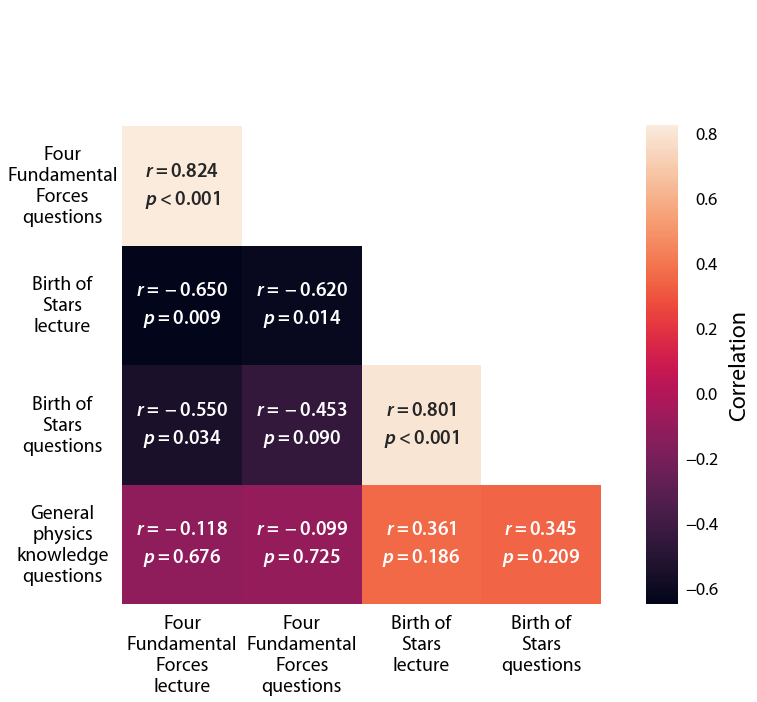

In [12]:
with (
    sns.plotting_context('talk', font_scale=1.1),
    warnings.catch_warnings(),
    # temporarily suppress harmless logged warnings:
    #     findfont: Font family ['cursive'] not found. Falling 
    #     back to DejaVu Sans.
    # and
    #     findfont: Generic family 'cursive' not found because 
    #     none of the following families were found: Apple 
    #     Chancery, Textile, Zapf Chancery, Sand, Script MT, 
    #     Felipa, Comic Neue, Comic Sans MS, cursive
    #
    # need to set 'mathtext.fontset' = 'custom' in order to set
    # 'mathtext.bf', but when 'mathtext.fontset' = 'custom',
    # matplotlib also tries to set 'mathtext.cal' = 'cursive'
    # internally and issues a warning because no cursive font 
    # families are installed in analysis container
    disable_logging('matplotlib.font_manager', 'ERROR'), 
    # make \mathit{} font bold & italic
    plt.rc_context({
        'mathtext.fontset': 'custom', 
        'mathtext.it': 'sans:semibold:italic',
        'mathtext.bf': 'sans:semibold'
    })
):
    # filter harmless warning about formatting labels without explicitly 
    # placing ticks -- seaborn takes care of this for us
    warnings.filterwarnings('ignore', 
                            message=('FixedFormatter should only be used '
                                     'together with FixedLocator'),
                            category=UserWarning)
    
    fig, ax = plt.subplots(figsize=(15, 11))
    cbar_ax = fig.add_axes([0.72, 0.125, 0.03, 0.605])
    ax = sns.heatmap(vars_corrmat, 
                     mask=mask, 
                     annot=pd.DataFrame(stat_array), 
                     fmt='', 
                     annot_kws=annot_kws,
                     xticklabels=ticklabels[:-1] + [''], 
                     yticklabels=[''] + ticklabels[1:], 
                     square=True, 
                     cbar_kws=cbar_kws,
                     ax=ax, 
                     cbar_ax=cbar_ax)
    
    ax.tick_params(axis='x', rotation=0, length=0, pad=10, labelsize='medium')
    ax.tick_params(axis='y', rotation=0, length=0, pad=60, labelsize='medium')
    ax.set_xticklabels(ax.get_xticklabels(), ha='center')
    ax.set_yticklabels(ax.get_yticklabels(), ha='center')
    
    cbar_ax.tick_params('y', length=0, pad=40)
    cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), ha='right')
    cbar_ax.set_ylabel(cbar_ax.get_ylabel(), fontsize='large', labelpad=10)
    
#     plt.savefig(FIG_DIR.joinpath('active-topics-corrmat.pdf'), 
#                 bbox_inches='tight')
    plt.show()

# Confidence intervals for correlations

In [13]:
for i, j in np.ndindex(ci_array.shape[:2]):
    if i > j:
        ci_low, ci_high = ci_array[i, j]
        x_label = ticklabels[i].replace('\n', ' ')
        y_label = ticklabels[j].replace('\n', ' ')
        print(f'{x_label} vs. {y_label}\n\t{ci_low = }\n\t{ci_high = }\n')

Four Fundamental Forces questions vs. Four Fundamental Forces lecture
	ci_low = 0.6958520051164606
	ci_high = 0.9725209798751722

Birth of Stars lecture vs. Four Fundamental Forces lecture
	ci_low = -0.9188997071995488
	ci_high = -0.2869827597846737

Birth of Stars lecture vs. Four Fundamental Forces questions
	ci_low = -0.8711796020493814
	ci_high = -0.32553039561177444

Birth of Stars questions vs. Four Fundamental Forces lecture
	ci_low = -0.8026101323399678
	ci_high = -0.2463692793220242

Birth of Stars questions vs. Four Fundamental Forces questions
	ci_low = -0.7022939663963504
	ci_high = -0.16723669297304572

Birth of Stars questions vs. Birth of Stars lecture
	ci_low = 0.5385106878454694
	ci_high = 0.957624897603092

General physics knowledge questions vs. Four Fundamental Forces lecture
	ci_low = -0.45943878822963313
	ci_high = 0.4320532464109732

General physics knowledge questions vs. Four Fundamental Forces questions
	ci_low = -0.4351461749301054
	ci_high = 0.38525948197105